# Start of script

RDKit WARNING: [14:20:34] Enabling RDKit 2019.09.3 jupyter extensions


mol_list_name:  phenothiazine-pyrene
Raw smiles list:
                                                name  \
0                             N-Pyrenylphenothiazine   
1    10-[3- (Pyrene-1-yl)-phenyl]-10-H-phenothiazine   
2       10-[4-(pyrene1-yl)-phenyl]-10H-phenothiazine   
3  3-[4-(1-pyrenyl)-phenyl]- 10-methyl-10H-phenot...   

                                       smiles string  
0   c1ccc3c(c1)sc2ccccc2n3c4cc5ccc6cccc7ccc(c4)c5c67  
1  c8cc(c1ccc2ccc3cccc4ccc1c2c34)cc(n7c5ccccc5sc6...  
2  c1ccc3c(c1)sc2ccccc2n3c8ccc(c4ccc5ccc6cccc7ccc...  
3  Cn8c1ccccc1sc7cc(c6ccc(c2ccc3ccc4cccc5ccc2c3c4...  


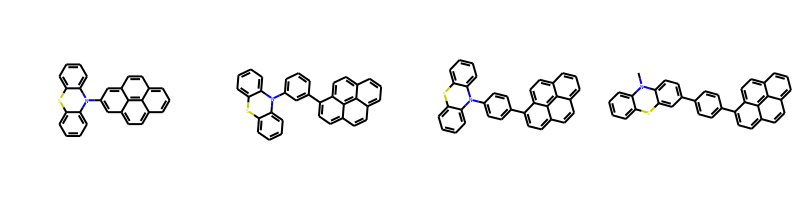

In [1]:
from Gaussain_Dushin_modules import *

#INPUTS ====================================================
input_file = "phenothiazine-pyrene"
run_theodore = True
states = [1,2,3,4] #initial state, final state
charges = [0,0,0,0] #initial charge, final charge

#============================================================

#loading molecules from list
smiles_list = pd.read_csv('/home/inferno/Bsc_Project/chem_structures/'+input_file+".csv")

#converting
input_structures = [Chem.MolFromSmiles(x) for x in smiles_list["smiles string"]]
input_visual=Draw.MolsToGridImage(input_structures,molsPerRow=4,subImgSize=(200,200))  


mol_list = input_structures
mol_list_name = input_file  #serial for molecule

remote_folder="/rds/general/user/gs920/home/Stage2/"
dushin_output_folder = os.getcwd()+"/dushin_outputs/"
theodore_installation_folder = "/home/inferno/Bsc_Project/TheoDORE_3.0/"
theodore_run_folder = os.getcwd()+"/Theodore_runs/"
hostname = 'login.hpc.ic.ac.uk'
username = 'gs920'
password= "Illusions9"



#info about system being ran

print("mol_list_name: ", mol_list_name)
print("Raw smiles list:")
print(smiles_list)

input_visual

In [5]:

status = "Started"
print("Status = ", status)

#conversion from smiles to gjf
for mol_num in range(0,len(mol_list)):
    mol_xyz = generate_XYZgeo_from_mol(mol_list, mol_list_name, mol_num)
    for state_num in range(0,len(states)):
        gjf_file = generate_Gjf_optfreqStates(mol_list, mol_list_name, mol_xyz, mol_num, states[state_num], charges[state_num], theodore = run_theodore)
        generate_shfile_gaussian(walltime='36:00:01', memory="30gb", ncpus=50, timeout="36h", molnumber= mol_num,
                             Excited_state = states[state_num], mollist_name= mol_list, gjf_file=gjf_file)
        run_job_HPC(hostname = hostname,username = username, password = password, remotefolder = remote_folder,\
                             molnumber = mol_num, Excited_state = states[state_num],mollist_name= mol_list_name, gjf_file= gjf_file)
        print("Queued job for: ",gjf_file)
        os.remove(gjf_file+".gjf")
        os.remove(gjf_file+".sh")
        
print("All Jobs uploaded")  
#check for completion
status = check_for_completion(hostname, username, password, max_loops = 300, wait_time = 180)


if status == "Gaussian completed":
    Error_mol_list = []

    for mol_num in range(0,len(mol_list)):
        try:
            for state_num in range(0,len(states),2):
                initial_state = "C" + str(charges[state_num]) + "S" + str(states[state_num])
                final_state = "C" + str(charges[state_num+1]) + "S" + str(states[state_num+1])


                #transfer gaussian log to local to parse, store useful data, and then delete log file

                mol_serial = mol_list_name+"_"+str(mol_num)+"_"+final_state
                reading_gaussian_output(hostname, username, password, remote_folder, mol_serial)

                #running and storing dushin
                run_dushin(hostname, username, password, remote_folder, mol_list, mol_list_name, mol_num, initial_state, final_state)


                filename = "dushin"+mol_list_name+"_"+str(mol_num)+"_"+initial_state+"_"+final_state+".log"
                transfer_from_HPC(hostname, username, password, dushin_output_folder, filename)
                reading_graphing_dushin_output(dushin_output_folder, filename)
        except:
            print("Dushin error for ",mol_list_name+"_"+str(mol_num))
            Error_mol_list.append(mol_list_name+"_"+str(mol_num))
        

else:
    print(status)






    
    

Status =  Started


/home/inferno/anaconda3/envs/Bsc_Project/lib/python3.7/site-packages/paramiko/client.py:839: UserWarning: Unknown ssh-ed25519 host key for login.hpc.ic.ac.uk: b'e34c53f357c63885633fb0f904838138'
  key.get_name(), hostname, hexlify(key.get_fingerprint())


Standard error:
b''
Exit status: 0
Queued job for:  phenothiazine-pyrene_0_C-2S0
Standard error:
b''
Exit status: 0
Queued job for:  phenothiazine-pyrene_0_C-3S0
Standard error:
b''
Exit status: 0
Queued job for:  phenothiazine-pyrene_1_C-2S0
Standard error:
b''
Exit status: 0
Queued job for:  phenothiazine-pyrene_1_C-3S0
Standard error:


KeyboardInterrupt: 

In [6]:
mol_xyz = generate_XYZgeo_from_mol(mol_list, mol_list_name, 0)
    